# Convolutional Neural Networks

This section covers some basics of convolutional neural networks (CNNs) in PyTorch, including the most important components of convolutional layers and associated operations (e.g. pooling). Some code in this notebook was adapted from [Dive Into Deep Learning, ch. 6](https://d2l.ai/chapter_convolutional-neural-networks/). The goal is to give an introduction to these operations so that you understand how to compose neural networks built from these operations.

Another excellent resource is the visualizations in this [convolution arithmetic tutorial](https://github.com/vdumoulin/conv_arithmetic#convolution-animations).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils
from tqdm import tqdm
import matplotlib.pyplot as plt

# Convolutions for Images

Convolutional layers are actually a misnomer, since the operations they express are more accurately described as cross-correlations. Here, we'll look at what the convolution (cross-correlation) operation looks like for a 2x2 convolutional kernel, shown below.

Here, we show a fixed kernel; however, it's important to remember that when training a neural network, these kernels are *learned* via SGD (or another optimization method).

![title](./correlation.png)

Notice how the output is *smaller* than the input. This means that, over several successive layers of convolution operations, our tensors can shrink to size zero if we don't monitor their size or combat the shrinkage with pooling (see below).

## Convolutional Layers

A convolutional *layer* cross-correlates the input and kernel and adds a scalar bias (not shown above) to produce an output. The two parameters of a convolutional layer are the kernel and the scalar bias. You can see how these are stored in PyTorch layers in the example below. 

When training models based on convolutional layers, we typically initialize the kernels randomly, just as we would with a fully-connected layer.

The convolutional layer output is sometimes called a *feature map*, as it can be regarded as the learned representations (features) in the spatial dimensions (e.g., width and height) to the subsequent layer. In CNNs, for any element  $x$  of some layer, its receptive field refers to all the elements (from all the previous layers) that may affect the calculation of $x$ during the forward propagation. Note that the receptive field may be larger than the actual size of the input.

In practice, our convolutional layers are composed of many kernels "stacked" on top of each other; the depth of these stacks corresponds to the `out_channels` argument in PyTorch's `Conv2D` layer.

## Padding

One tricky issue when applying convolutional layers is that we tend to lose pixels on the perimeter of our image. Since we typically use small kernels, for any given convolution, we might only lose a few pixels, but this can add up as we apply many successive convolutional layers. 

One straightforward solution to this problem is to "pad" the inputs before applying convolution: add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to zero. 

In the figure below, we pad a  $3×3$  input, increasing its size to  $5×5$. The corresponding output then increases to a  $4×4$  matrix. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation:  $0×0+0×1+0×2+0×3=0$ .

![title](./padding.png)

In general, if we add a total of  $p_h$  rows of padding (roughly half on top and half on bottom) and a total of  $pw$  columns of padding (roughly half on the left and half on the right), the output shape will be

\begin{equation}
(n_h − k_h + p_h +1)×(n_w − k_w + p_w + 1).
\end{equation}
 
This means that the height and width of the output will increase by $p_h$ and  $p_w$, respectively, relative to the output size without padding. Note that $n_h$ and $n_w$ are the input height and width; $k_h$ and $k_w$ are the kernel height and width.

In many cases, we will want to set  𝑝ℎ=𝑘ℎ−1  and  𝑝𝑤=𝑘𝑤−1  to give the input and output the same height and width. This will make it easier to predict the output shape of each layer when constructing the network. Assuming that  𝑘ℎ  is odd here, we will pad  𝑝ℎ/2  rows on both sides of the height. If  𝑘ℎ  is even, one possibility is to pad  ⌈𝑝ℎ/2⌉  rows on the top of the input and  ⌊𝑝ℎ/2⌋  rows on the bottom. We will pad both sides of the width in the same way.

CNNs commonly use convolution kernels with odd height and width values, such as 1, 3, 5, or 7. Choosing odd kernel sizes has the benefit that we can preserve the spatial dimensionality while padding with the same number of rows on top and bottom, and the same number of columns on left and right.

## Stride

When computing the cross-correlation, we start with the convolution window at the upper-left corner of the input tensor, and then slide it over all locations both down and to the right. In previous examples, we default to sliding one element at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations.

We refer to the number of rows and columns traversed per slide as the stride. So far, we have used strides of 1, both for height and width. Sometimes, we may want to use a larger stride. The figure below shows a two-dimensional cross-correlation operation with a stride of 3 vertically and 2 horizontally. The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation:  0×0+0×1+1×2+2×3=8 ,  0×0+6×1+0×2+0×3=6 . We can see that when the second element of the first column is outputted, the convolution window slides down three rows. The convolution window slides two columns to the right when the second element of the first row is outputted. When the convolution window continues to slide two columns to the right on the input, there is no output because the input element cannot fill the window (unless we add another column of padding).

![title](./stride.png)


In general, when the stride for the height is  𝑠ℎ  and the stride for the width is  𝑠𝑤 , the output shape is

\begin{equation}
\lfloor (nh−kh+ph+sh) / sh \rfloor \times \lfloor (nw−kw+pw+sw) / sw \rfloor
\end{equation}


If we set  𝑝ℎ=𝑘ℎ−1  and  𝑝𝑤=𝑘𝑤−1 , then the output shape will be simplified to  $\lfloor (nh+sh−1)/sh \rfloor \times \lfloor (nw+sw−1)/sw \rfloor$ . Going a step further, if the input height and width are divisible by the strides on the height and width, then the output shape will be  $(nh/sh)×(nw/sw)$.



## Pooling

Often, as we process images, we want to gradually reduce the spatial resolution of our hidden representations, aggregating information so that the higher up we go in the network, the larger the receptive field (in the input) to which each hidden node is sensitive.

Like convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (sometimes known as the pooling window). However, unlike the cross-correlation computation of the inputs and kernels in the convolutional layer, the pooling layer contains no parameters (there is no kernel). Instead, pooling operators are deterministic, typically calculating either the maximum or the average value of the elements in the pooling window. These operations are called maximum pooling (max pooling for short) and average pooling, respectively.

In both cases, as with the cross-correlation operator, we can think of the pooling window as starting from the upper-left of the input tensor and sliding across the input tensor from left to right and top to bottom. At each location that the pooling window hits, it computes the maximum or average value of the input subtensor in the window, depending on whether max or average pooling is employed.

![title](./pooling.png)


# Convolution In A Neural Network

Below is an implementation a simple convolutional network We use `torchinfo-summary()` to view the size of the data as it flows through the network; additionally, we print and the size of the weights and biases of the layers during a forward pass. (You won't normally need to access the weights/biases directly when training models in PyTorch; this is purely for illustration.)

Next, we'll compare this simple CNN with a fully-connected network, to see how we benefit from using convolution during training. We construct a similar, densely-connected network with around 2x the parameters of our CNN.

In [2]:
from torchinfo import summary

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)  # in_channels, out_channels, kernel_size, stride, padding
        self.max1 = nn.MaxPool2d(2, 2, 0)  # kernel_size, stride, padding
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 0)
        self.max2 = nn.MaxPool2d(2, 2, 1)
        self.conv3 = nn.Conv2d(32, 64, 1, 1, 0)
        self.conv4 = nn.Conv2d(64, 4, 5, 1, 0)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(36, 10)
    
    @property
    def trainable_layers(self):
        """A utility property to easily access a list of all model layers."""
        return [self.conv1, self.conv2, self.conv3, self.conv4, self.linear1]
        
    def forward(self, inputs):
        """Implements the forward pass."""
        x = self.conv1(inputs)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

    def print_weight_shapes(self):
        """Utility function to print the shapes of weights in trainable layers."""
        for layer in self.trainable_layers:
            print(f"Weight shape: {layer.weight.shape}; Bias shape: {layer.bias.shape}")

conv_net = ConvNet()
batch_size = 64
summary(conv_net, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 12, 12]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 64, 7, 7]            2,112
├─Conv2d: 1-6                            [64, 4, 3, 3]             6,404
├─Flatten: 1-7                           [64, 36]                  --
├─Linear: 1-8                            [64, 10]                  370
Total params: 13,686
Trainable params: 13,686
Non-trainable params: 0
Total mult-adds (M): 0.93
Input size (MB): 0.20
Forward/backward pass size (MB): 10.41
Params size (MB): 0.05
Estimated Total Size (MB): 10.67

In [3]:
conv_net.print_weight_shapes()

Weight shape: torch.Size([16, 1, 3, 3]); Bias shape: torch.Size([16])
Weight shape: torch.Size([32, 16, 3, 3]); Bias shape: torch.Size([32])
Weight shape: torch.Size([64, 32, 1, 1]); Bias shape: torch.Size([64])
Weight shape: torch.Size([4, 64, 5, 5]); Bias shape: torch.Size([4])
Weight shape: torch.Size([10, 36]); Bias shape: torch.Size([10])


In [4]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28 * 28, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


fc_net = FCNet()
summary(fc_net)
summary(fc_net, input_size=(batch_size, 1, 28,28))


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [64, 16]                  12,560
├─Linear: 1-2                            [64, 10]                  170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.20
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.26

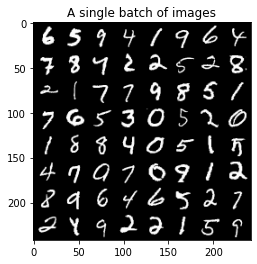

In [5]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())


# Construct the DataLoader and show one batch
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

# Show one batch of images. Each batch of images has shape [batch_size, 1, 28, 28],
# where 1 is the "channels" dimension of the image.
for images,labels in train_loader:
    grid_img = torchvision.utils.make_grid(images)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("A single batch of images")
    break

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)
optimizer_fc = optim.SGD(fc_net.parameters(), lr=0.001, momentum=0.9)

In [7]:
from tqdm import tqdm

print_every_iters = 150

for epoch in range(2):  # loop over the dataset multiple times

    fc_total_loss = 0.0
    cnn_total_loss = 0.0
    
    for i, data in tqdm(enumerate(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_cnn.zero_grad()
        optimizer_fc.zero_grad()

        # forward + backward + optimize on CNN
        outputs = conv_net(inputs)
        cnn_loss = criterion(outputs, labels)
        cnn_loss.backward()
        optimizer_cnn.step()
        
        # forward + backward + optimize on FC
        outputs = conv_net(inputs)
        fc_loss = criterion(outputs, labels)
        fc_loss.backward()
        optimizer_cnn.step()

        # print statistics
        fc_total_loss += fc_loss.item()
        cnn_total_loss += cnn_loss.item()
        if i % print_every_iters == 0:    # print train loss every 100 mini-batches
            print('[epoch %d, step %5d] cnn train loss: %.3f' %
                  (epoch + 1, i + 1, cnn_total_loss / (print_every_iters * (i+1))))
            print('[epoch %d, step %5d] fc train loss: %.3f' %
                  (epoch + 1, i + 1, fc_total_loss / (print_every_iters * (i+1))))

print('Finished Training')

5it [00:00, 19.72it/s]

[epoch 1, step     1] cnn train loss: 0.015
[epoch 1, step     1] fc train loss: 0.015


155it [00:06, 24.82it/s]

[epoch 1, step   151] cnn train loss: 0.014
[epoch 1, step   151] fc train loss: 0.014


305it [00:12, 24.63it/s]

[epoch 1, step   301] cnn train loss: 0.009
[epoch 1, step   301] fc train loss: 0.009


455it [00:18, 25.00it/s]

[epoch 1, step   451] cnn train loss: 0.007
[epoch 1, step   451] fc train loss: 0.007


605it [00:24, 25.84it/s]

[epoch 1, step   601] cnn train loss: 0.006
[epoch 1, step   601] fc train loss: 0.006


755it [00:30, 25.34it/s]

[epoch 1, step   751] cnn train loss: 0.005
[epoch 1, step   751] fc train loss: 0.005


905it [00:35, 25.76it/s]

[epoch 1, step   901] cnn train loss: 0.004
[epoch 1, step   901] fc train loss: 0.004


938it [00:37, 26.80it/s]
6it [00:00, 24.40it/s]

[epoch 2, step     1] cnn train loss: 0.002
[epoch 2, step     1] fc train loss: 0.002


156it [00:06, 25.79it/s]

[epoch 2, step   151] cnn train loss: 0.001
[epoch 2, step   151] fc train loss: 0.001


306it [00:12, 25.78it/s]

[epoch 2, step   301] cnn train loss: 0.001
[epoch 2, step   301] fc train loss: 0.001


456it [00:17, 25.74it/s]

[epoch 2, step   451] cnn train loss: 0.001
[epoch 2, step   451] fc train loss: 0.001


606it [00:23, 25.27it/s]

[epoch 2, step   601] cnn train loss: 0.001
[epoch 2, step   601] fc train loss: 0.001


756it [00:29, 25.39it/s]

[epoch 2, step   751] cnn train loss: 0.001
[epoch 2, step   751] fc train loss: 0.001


906it [00:35, 25.56it/s]

[epoch 2, step   901] cnn train loss: 0.001
[epoch 2, step   901] fc train loss: 0.001


938it [00:36, 25.41it/s]

Finished Training


In [8]:
fc_total_loss = 0.0
cnn_total_loss = 0.0

for i, data in tqdm(enumerate(test_loader, 0)):
    inputs, labels = data
    cnn_loss = criterion(conv_net(inputs), labels)
    fc_loss = criterion(fc_net(inputs), labels)
    fc_total_loss += fc_loss.item()
    cnn_total_loss += cnn_loss.item()
    
print(f"CNN test loss is {cnn_total_loss/len(test_loader)}")
print(f"FC net test loss is {fc_total_loss/len(test_loader)}")

157it [00:02, 75.85it/s]

CNN test loss is 0.10700725481673411
FC net test loss is 2.3106368286594465
